## Testing networkx to pass on to interactive API

In [1]:
import csv
import numpy as np
import glob
import matplotlib.pyplot as plt
import json

In [2]:
# plt-specific:
%matplotlib inline
from IPython.display import display
from PIL import Image
import matplotlib.image as mpimg 

In [3]:
# nc-specific:
import networkx as nx
from networkx.readwrite import json_graph

Get edges. Likely passed as parameter to function later on.

In [4]:
with open("example_output.txt", "r") as readfile:
    reader = csv.reader(readfile)
    edges = [ edge[0] for edge in reader]

# compile list of molecule names:
ligands = []
for edge in edges:
    ligA = edge.split("-")[0]
    ligB = edge.split("-")[1]  
    if not ligA in ligands:
        ligands.append(ligA)
    if not ligB in ligands:
        ligands.append(ligB)

Check out the perturbations using the preconstructed images. Need to figure out how to generate images on the fly using temp mol images.

In [5]:
def plotPertEdge(ligA, ligB):
    """Given two ligand names, plot an axis with both molecular images side by side."""
    
    # define image path.
    imgs_path = "./mol_imgs/"
    
    # read in images. Fails verbosely by default.
    imgA = mpimg.imread(imgs_path+ligA+".png")
    imgB = mpimg.imread(imgs_path+ligB+".png")
    
    # create plot with two subplots, one for each ligand.
    f, ax = plt.subplots(1, 2, figsize=(6,3))
    
    # plot images and remove axes.
    ax[0].imshow(imgA)
    ax[1].imshow(imgB)
    for axis in ax:
        axis.axis('off')
    
    plt.show()

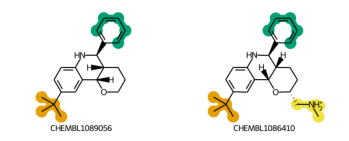

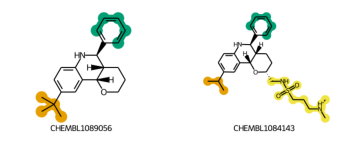

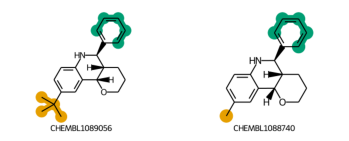

In [6]:
# plot the first three edges:
for edge in edges[:3]:
    ligA = edge.split("-")[0]
    ligB = edge.split("-")[1]
    plotPertEdge(ligA, ligB)


Construct a simple networkx graph using the example_output.txt file where nodes are labeled with ligand names (will be mol imgs later).

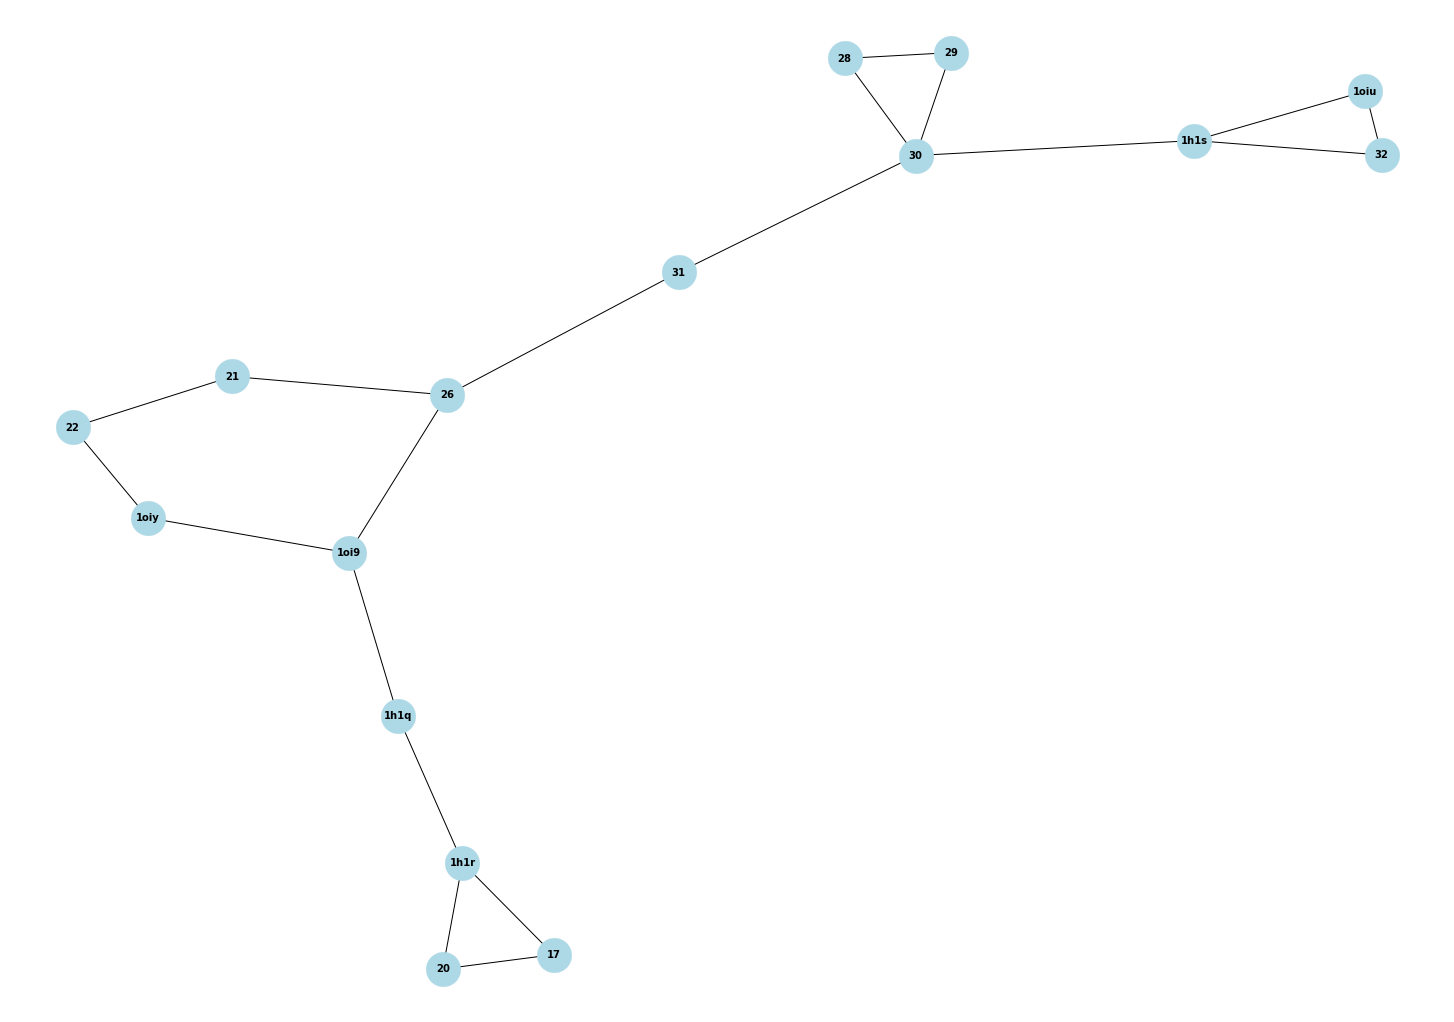

In [7]:
# take the standard networkx approach for now:
plt.figure(figsize=(20,14))
G = nx.Graph()
G.add_nodes_from(ligands)

# need to convert to iterable tuples for this nx function:
edges_tupled = [(edge.split("-")[0], edge.split("-")[1]) for edge in edges]
G.add_edges_from(edges_tupled)
nx.draw(G, node_size=1200, node_color='lightblue', linewidths=0.25, \
    font_size=10, font_weight='bold', with_labels=True)
plt.show()

Export G as JSON, use http_server to generate force-directed graph with images of mols:

networkx->.js:
https://www.alanzucconi.com/2015/11/01/interactive-graphs-in-the-browser/#step3
-> this guide is incomplete. Will have to find alternative to work in notebook. Regardless, will have to work in separate html/javascript/css files at some point. Instead, code mostly derived from:

https://andrewmellor.co.uk/blog/articles/2014/12/14/d3-networks/
(see bottom for more elaborate examples)

image as node:
https://stackoverflow.com/questions/7306250/does-force-directed-layout-of-d3-js-support-image-as-node
(see comments on circles etc)

element deletion:
https://stackoverflow.com/questions/24355451/d3-how-delete-shape-on-click-event
(ish)

Interactive feature ideas:
- create new edge 
- delete edge
- delete node
- undo
- easy zoom in/out
    - https://stackoverflow.com/questions/7871425/is-there-a-way-to-zoom-into-a-d3-force-layout-graph
    
    - or all of the above:https://bl.ocks.org/cjrd/6863459
- allocate more/less sampling?
- make an edge single direction?
- Chem. information on hover
- preset # of edges

In [8]:
# Mimic the example by converting node IDs to indeces. 
# Compound ID is retained (could be written to file too).
G = nx.convert_node_labels_to_integers(G,label_attribute='cmpd_id')

In [9]:
# write graph to JSON file.
data = json_graph.node_link_data(G)
with open('graph.json', 'w') as f:
    json.dump(data, f, indent=4)

Generate html object:

In [43]:
%%html
<div id="d3-container"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

Fill with JS graph:

In [44]:
%%javascript
// We load the latest version of d3.js from the Web.
require.config({paths: {d3: "https://d3js.org/d3.v4.min"}});
require(["d3"], function(d3) {

    // Parameter declaration, the height and width of our viz.
    var width = 800,
        height = 600;

    // Colour scale for node colours.
    var color = d3.scale.category10();

    // We create a force-directed dynamic graph layout.
    // D3 has number of layouts - refer to the documentation.
    var force = d3.layout.force()
        .charge(-120)
        .linkDistance(50)
        .size([width, height]);

    // We select the < div> we created earlier and add an 
    // SVG = Scalable Vector Graphics
    var svg = d3.select("#d3-container").select("svg")
    if (svg.empty()) {
        svg = d3.select("#d3-container").append("svg")
                    .attr("width", width)
                    .attr("height", height);
    }

    // We load the JSON network file.
    d3.json("graph.json", function(error, graph) {
        // Within this block, the network has been loaded
        // and stored in the 'graph' object.

        // We load the nodes and links into the force-directed
        // graph and initialise the dynamics.
        force.nodes(graph.nodes)
            .links(graph.links)
            .start();

        // We create a < line> SVG element for each link
        // in the graph.
        var link = svg.selectAll(".link")
            .data(graph.links)
            .enter().append("line")
            .attr("class", "link");

        // We create a < circle> SVG element for each node
        // in the graph, and we specify a few attributes.
        var node = svg.selectAll(".node")
            .data(graph.nodes)
            .enter().append("circle")
            .attr("class", "node")
            .attr("r", 5)  // radius
            .style("fill", function(d) {
                // We colour the node depending on the ID. Later can be changed into some other var.
                return color(d.id); 
            })
            .call(force.drag);

        // The label each node its node number from the networkx graph.
        node.append("title")
            .text(function(d) { return d.id; });



        // We bind the positions of the SVG elements
        // to the positions of the dynamic force-directed graph,
        // at each time step.
        force.on("tick", function() {
            link.attr("x1", function(d) { return d.source.x; })
                .attr("y1", function(d) { return d.source.y; })
                .attr("x2", function(d) { return d.target.x; })
                .attr("y2", function(d) { return d.target.y; });

            node.attr("cx", function(d) { return d.x; })
                .attr("cy", function(d) { return d.y; });
        });
    });
});

<IPython.core.display.Javascript object>

scroll up for interactive graph.

Test how scalable this is. Can we do >50 ligands?

In [12]:
import random
# make a toy graph in nx with n nodes and random edges.
num_ligands = 350
G = nx.complete_graph(num_ligands)

edges_to_remove_collection = []
for node in G.nodes():
    # keep two random edges by appending all but two edges to list.     
    edges_to_remove = random.sample(list(G.edges(node)), int(num_ligands*0.9))
    for edge in edges_to_remove:
        edges_to_remove_collection.append(edge)
for edge in edges_to_remove_collection:
    try:
        G.remove_edge(*edge)
    # will throw NetworkXError when edge already deleted:
    except:
        pass

In [13]:
# write graph to JSON file.
data = json_graph.node_link_data(G)
with open('graph_large.json', 'w') as f:
    json.dump(data, f, indent=4)

In [14]:
%%html
<div id="d3-container_large"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>